<a href="https://colab.research.google.com/github/jhu-nanoenergy/VAE-models/blob/main/AE_framework_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Helpful tutorial / example links
# https://github.com/timbmg/VAE-CVAE-MNIST/blob/master/models.py
# https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [2]:
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.stats as stat
import pandas as pd
import numpy as np
import os
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
import torch.optim as optim
import argparse
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint 
import h5py

import gc

from torch import autograd

!pip install -q -U torchinfo
from torchinfo import summary

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)


Mounted at /content/drive/


In [4]:
# hyperparameters
full_data_num = 500 #amount of data to use from EACH int / ext dataset
bsize = 12 #careful making batch size bigger 


latent_features = 16
epochs = 10
lr = 1e-6
w_d = 1e-5


spec_points = 219
num_segments = 2

# for defining network
fv = [256, 256, 512, 1024, 2048] #Channels/Convolutions of Images
ks = 3 #kernel size
feat_size = 512 #Feature Space Size
mv_size = 20 #Latent space sampling size (mean and variance)

In [5]:


# Get all data from drive
int_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/int_total_sqr_no_struct.mat', squeeze_me=True)
# ext_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/ext_total_sqr_no_struct.mat', squeeze_me=True)
wavelengths = int_data_all['lambda']
wavelengths = np.delete(wavelengths,np.where(wavelengths==[0.5]))
wavelengths = np.delete(wavelengths,np.where(wavelengths==[1]))
wavelengths = np.transpose(np.tile(wavelengths,(3,1)))

In [6]:
print(np.shape(wavelengths))


(219, 3)


In [7]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
fname_mask = '/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData.h5'

hdf_file = h5py.File(fname_mask, "r")
print(list(hdf_file.keys()))

# dext = hdf_file['ext']
dext_spectra = hdf_file['ext/maskCell']
dint_spectra = hdf_file['int/maskCell']
combined = np.concatenate((dext_spectra[:11],dint_spectra[:11]), axis=0)
# print(dext.keys())
print(np.shape(combined))

['ext', 'int']
(22, 256, 256)


In [8]:
class ImageDataset(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ):
        super(Dataset, self).__init__()
        dext_height = hf['ext/height']
        dint_height = hf['int/height']
        dext_spectra = hf['ext/spectCell']
        dint_spectra = hf['int/spectCell']
        self.spectra = torch.from_numpy(np.concatenate((dext_spectra[:datanum], dint_spectra[:datanum]), axis=0))
        # print(sum(self.spectra!=self.spectra))
        
        self.heights = torch.from_numpy(np.concatenate((dext_height[:datanum],dint_height[:datanum]), axis=0))
        # self.heights = htemp.unsqueeze(1)

        self.masks = np.concatenate((hf['ext/maskCell'][:datanum],hf['int/maskCell'][:datanum]), axis=0)
        # could use sreyas size calculation instead, not sure
        self.sizes =  torch.from_numpy(np.concatenate((hf['ext/size'][:datanum],hf['int/size'])[:datanum], axis=0))
        ext_label = np.ones((np.shape(dext_height)))
        int_label = np.zeros((np.shape(dint_height)))
        self.labels = torch.from_numpy(np.concatenate( (ext_label, int_label), axis=0))
        self.transform = transform  
              

    def __len__(self):
        return len(self.heights)

    def __getitem__(self, idx):
        image = (self.masks[idx,:,:])
        
        # height= np.around( self.heights[idx], decimals=1)
        spectra = (( self.spectra[idx] ))
        if self.transform:
            image = self.transform(image)
            

        return image, spectra
        # return image, spectra, height

In [9]:
# class ModuleWrapperIgnores2ndArg(nn.Module):
#     def __init__(self, module):
#         super().__init__()
#         self.module = module

#     def forward(self,x, dummy_arg=None):
#         assert dummy_arg is not None
#         x = self.module(x)
#         return x



```
 
```

# Feature Extraction Network inserted into Encoder

In [10]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    # encoder, aka Feature Extraction Network
    # self.enc1 = nn.Linear(in_features=(256*256), out_features=1024)

    self.enc1 = nn.Sequential( # Feature Extraction Network extraction_layers
            # Conv_1 
            nn.Conv2d(1, fv[0], kernel_size=ks, stride=1, padding="same"),
            nn.BatchNorm2d(fv[0]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            # Conv_2 + Pool_1
            nn.Conv2d(fv[0], fv[1], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[1]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),  
            nn.MaxPool2d(2,2),

            # Conv_3 + Pool_2
            nn.Conv2d(fv[1], fv[2], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[2]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),

            # Conv_4 + Pool_3
            nn.Conv2d(fv[2], fv[3], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[3]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),
        )
    self.enc2 = nn.Linear(32*32*1024, feat_size) # Feature Extraction Network feature_layer
    # self.enc2 = nn.Linear(1024, feat_size) #reducing to 512

    # self.dummy_tensor = torch.ones(1, dtype=torch.float, requires_grad = True)    
    # self.module_wrapper = ModuleWrapperIgnores2ndArg(self.enc1)


    # prediction network
    # self.pred1 = nn.Linear(in_features=512, out_features=(spec_points*3))
    self.pred1 = nn.Sequential(
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, spec_points*3)
        )


    # recognition network
    self.rec1 = nn.Linear(in_features=feat_size + (spec_points*3), out_features=latent_features*2)



  def forward(self, x):
    # encoding
    # e = F.relu(self.enc1(x))
    
    # x = (x.view(bsize, 1, 256, 256))
    x = (x.view(int(torch.numel(x)/256/256), 1, 256, 256)) #usually batch size in first arg
    
    x = self.enc1(x)
    # x = checkpoint(self.module_wrapper,x,self.dummy_tensor)

    e = x.view(int(torch.numel(x)/32/32/1024), 32*32*1024) #usually batch size in first arg
    e = self.enc2(e)
    
    
    e = torch.unsqueeze(e,1)
    e = torch.unsqueeze(e,1)
    p = torch.sigmoid(self.pred1(e))  
    # p = self.pred1(e)  

    input_rec = torch.cat((e,p), 3)

    # x = torch.clamp( self.rec1(input_rec).view(-1, 2, latent_features) , -100, 100)
    x = self.rec1(input_rec).view(-1, 2, latent_features)
    # print(x.size())
    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance


    return p, mu, log_var

In [11]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    # decoder 
    self.dec1 = nn.Linear(in_features= spec_points*3 +latent_features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=(256*256))


  def forward(self, spectra,latent):
    # encoding
    input_dec = torch.cat((spectra,latent),1)

    # decoding
    x = F.relu(self.dec1(input_dec))
    reconstruction =  torch.sigmoid(self.dec2(x) )
    return reconstruction 

In [12]:
# primary VAE module

class CustomVAE(nn.Module):
    def __init__(self):
        super(CustomVAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
      
        x = self.encoder(x)  
        spectra, mu, log_var  = x 

        # temporarily make spectra a 2D instead of a 4D vector     
        spectra = torch.squeeze(spectra)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder( spectra, z )
        return recon_x, mu, log_var, spectra

    # DEFINE SPECTRA PREDICTION FUNCTION 


    def inference(self, spectra, z):
      recon_x = self.decoder( spectra, z )
      return recon_x



In [13]:
# DEFINE RANDOM SEED 
# CREATE VALIDATION SET AND FIX MEMORY ISSUES AHHHHHHHHHHH
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
full_dataset = ImageDataset(hdf_file, full_data_num )

In [14]:

# print(torch.cuda.memory_summary(device=None, abbreviated=False))
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
data_temp, data_test = torch.utils.data.random_split(full_dataset, [train_size+val_size, test_size])

data_train, data_val = torch.utils.data.random_split(data_temp, [train_size, val_size])

train_dataloader = DataLoader(data_train, batch_size = bsize, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size = bsize)
valid_dataloader = DataLoader(data_val, batch_size = bsize)
print(len(train_dataloader))
print(len(test_dataloader))
print(len(valid_dataloader))
print(len(full_dataset))

59
9
17
1000


In [15]:
# torch.cuda.empty_cache()

del hdf_file, int_data_all, data_temp
gc.collect()

250

In [16]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
model_custom = CustomVAE().cuda()
print(summary(model_custom, input_size = (bsize,1,256,256)))
# optimizer = optim.Adam(model_custom.parameters(), lr=lr)
optimizer = optim.SGD(model_custom.parameters(), lr=lr, weight_decay = w_d)
# print("took out bce loss idk!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
criterion_mask = nn.BCELoss(reduction='sum')
# criterion_mask = nn.MSELoss()
criterion = nn.MSELoss()

Layer (type:depth-idx)                   Output Shape              Param #
CustomVAE                                --                        --
├─Encoder: 1-1                           [12, 1, 1, 657]           --
│    └─Sequential: 2-1                   [12, 1024, 32, 32]        --
│    │    └─Conv2d: 3-1                  [12, 256, 256, 256]       2,560
│    │    └─BatchNorm2d: 3-2             [12, 256, 256, 256]       512
│    │    └─LeakyReLU: 3-3               [12, 256, 256, 256]       --
│    │    └─Conv2d: 3-4                  [12, 256, 256, 256]       590,080
│    │    └─BatchNorm2d: 3-5             [12, 256, 256, 256]       512
│    │    └─LeakyReLU: 3-6               [12, 256, 256, 256]       --
│    │    └─MaxPool2d: 3-7               [12, 256, 128, 128]       --
│    │    └─Conv2d: 3-8                  [12, 512, 128, 128]       1,180,160
│    │    └─BatchNorm2d: 3-9             [12, 512, 128, 128]       1,024
│    │    └─LeakyReLU: 3-10              [12, 512, 128, 128]     

In [17]:
def final_loss(loss1_bce, loss2_mse, mu, logvar):
    """
    This function will add the reconstruction loss and the  KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    alpha = 2
    # print(mu)
    # print(logvar)
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = 0
    # print(KLD)
    return (loss1_bce + alpha*loss2_mse + KLD)



In [18]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataloader)/dataloader.batch_size)):
      if torch.cuda.is_available():
          data, spectra_in = [d.cuda( ) for d in data]
          data = data.view(data.size(0), -1)
          optimizer.zero_grad()
        # with autograd.detect_anomaly():
          reconstruction, mu, logvar, out_spectra = model(data)
          pout = out_spectra.view(-1, 3, spec_points)      
          
          
          reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
          reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  

          bce_loss = criterion_mask(reconstruction, data)
          
          # print(bce_loss)
          # print(pout)
          mse_loss = criterion(spectra_in.float(), pout)
          # print(torch.isfinite(pout).all())
          
          # print(mse_loss)
          loss = final_loss(bce_loss, mse_loss, mu, logvar)
          running_loss += loss.item()
          # loss.backward(retain_graph=False)
          
          loss.backward()
          optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss
    
def validate(model, dataloader, plot_on):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataloader)/dataloader.batch_size)):
        data, spectra_in = [d.cuda( ) for d in data]
        data = data.view(data.size(0), -1)
        reconstruction, mu, logvar, out_spectra = model(data)
        pout = out_spectra.view(-1, 3, spec_points)

        reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
        reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  
        
        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()

        # save the last batch input and output 
        if plot_on:
          # print(i)
          if i == bsize - 2:
            # both = torch.cat((data.view(batch_size, 1, 256, 256)[:4],  
            #                   reconstruction.view(batch_size, 1, 256, 256)[:4]))
            print("MSE loss: " + str(mse_loss))
            num_replicas = 4
            fig, axs = plt.subplots(2,num_replicas)
            for x in range( num_replicas ):
      
              axs[0,x].imshow(torch.squeeze(data.view(bsize, 1, 256, 256)[x]).cpu())
              axs[0,x].xaxis.set_visible(False)
              axs[0,x].yaxis.set_visible(False)
              axs[1,x].imshow(torch.squeeze(reconstruction.view(bsize, 1, 256, 256)[x]).cpu())
              axs[1,x].xaxis.set_visible(False)
              axs[1,x].yaxis.set_visible(False)
            fig.suptitle(str(epoch+1))

            og = spectra_in[0].detach().cpu().numpy()
            pred = pout[0].detach().cpu().numpy()
            
            # pout = p.view(-1, 3, spec_points)
            fig2, axs = plt.subplots(2,1)
            axs[0].plot(wavelengths, np.transpose(og) )
            axs[1].plot(wavelengths, np.transpose(pred) )
            fig2.suptitle(str(epoch+1))
            fig.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}geom_output.png")
            fig2.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}spectra_output.png")
            plt.show()
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [19]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2205 MB |    8362 MB |   13861 MB |   11655 MB |
|       from large pool |    2203 MB |    8360 MB |   13858 MB |   11655 MB |
|       from small pool |       2 MB |       2 MB |       2 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    2205 MB |    8362 MB |   13861 MB |   11655 MB |
|       from large pool |    2203 MB |    8360 MB |   13858 MB |

Epoch 1 of 10


59it [00:19,  3.08it/s]
10it [00:01,  9.87it/s]

MSE loss: tensor(0.1293, device='cuda:0')


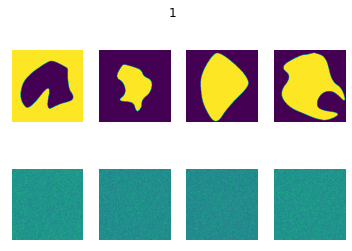

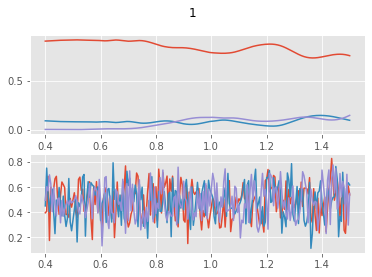

17it [00:02,  7.05it/s]


Train Loss: 45426.8408
Val Loss: 45394.7462
Epoch 2 of 10


59it [00:19,  3.10it/s]
17it [00:01, 10.37it/s]


Train Loss: 45366.1514
Val Loss: 45343.7428
Epoch 3 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.36it/s]


Train Loss: 45307.6592
Val Loss: 45271.2445
Epoch 4 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.38it/s]


Train Loss: 45205.5665
Val Loss: 45138.2905
Epoch 5 of 10


59it [00:18,  3.11it/s]
9it [00:00, 10.20it/s]

MSE loss: tensor(0.1464, device='cuda:0')


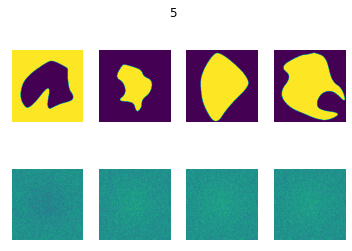

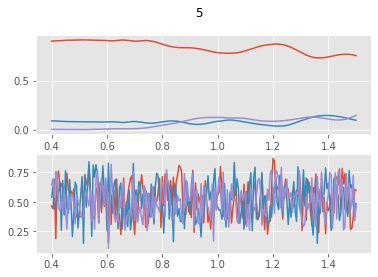

17it [00:02,  7.40it/s]


Train Loss: 45013.8269
Val Loss: 44885.5022
Epoch 6 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.37it/s]


Train Loss: 44647.5944
Val Loss: 44395.1380
Epoch 7 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.34it/s]


Train Loss: 43933.2733
Val Loss: 43436.6811
Epoch 8 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.37it/s]


Train Loss: 42557.1330
Val Loss: 41576.3228
Epoch 9 of 10


59it [00:18,  3.11it/s]
17it [00:01, 10.35it/s]


Train Loss: 39906.7819
Val Loss: 38007.8448
Epoch 10 of 10


59it [00:18,  3.11it/s]
10it [00:00, 10.25it/s]

MSE loss: tensor(0.1436, device='cuda:0')


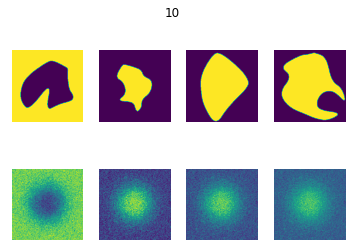

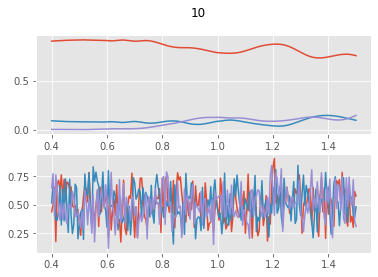

17it [00:02,  7.43it/s]

Train Loss: 34849.8218
Val Loss: 31636.5652


In [20]:

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
    train_epoch_loss = fit(model_custom, train_dataloader)
    if epoch == 0 or not ((epoch+1) % 5):
      val_epoch_loss = validate(model_custom, valid_dataloader, 1)
    else:
      val_epoch_loss = validate(model_custom, valid_dataloader, 0)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

In [21]:
!nvidia-smi

Thu Mar 17 20:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    48W / 300W |  14227MiB / 16160MiB |     60%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
print(torch.__version__)

1.10.0+cu111
